This version uses my own angular_distance script and is not as efficient as the other version.

In [1]:
%matplotlib inline
from __future__ import division, print_function
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import fitsio
import sys, os
import matplotlib.patches as patches
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import wcs

sys.path.append('/Users/roz18/git/Python/user_modules')
import angular_distance

In [2]:
def create_wcs(coadd_id):
    '''
    Create Astropy WCS object.
    '''
    # Create a new WCS object
    w = wcs.WCS(naxis=2)
    # Set up gnomonic projection
    w.wcs.ctype = ["RA---TAN", "DEC--TAN"]
    # WCS parameters
    w.wcs.cd = coadd['CD'][coadd_id]
    w.wcs.crval = coadd['CRVAL'][coadd_id]
    w.wcs.crpix = coadd['CRPIX'][coadd_id]
    # CDELT is ignored since cd is present
    # # w.wcs.cdelt = coadd['CDELT'][coadd_id]
    w.wcs.lonpole = coadd['LONGPOLE'][coadd_id]
    w.wcs.latpole = coadd['LATPOLE'][coadd_id]
    # Epoch must be defined
    w.wcs.equinox = 2000.
    
    return w

In [3]:
##########################################################
# Match objects to nearest coadds
coadd = fitsio.read('/Users/roz18/git/wise-mask-query/misc/astrom-atlas_radec_added.fits')
cat = fitsio.read('/Users/roz18/Documents/Data/desi_photoz/random_forest/lrg_20171106_rf_photoz_v0.1.fits', 
    columns=['ra', 'dec'])

In [9]:
ra1=np.array(coadd['ra_center'])
dec1=np.array(coadd['dec_center'])
ra2=np.array(cat['ra'])
dec2=np.array(cat['dec'])
skycat1=SkyCoord(ra1*u.degree,dec1*u.degree, frame='icrs')
skycat2=SkyCoord(ra2*u.degree,dec2*u.degree, frame='icrs')

# Find the nearest 3 coadds for each object
idx_all_three = np.zeros([3, len(cat)], dtype=int)
idx_all_three[0], d2d_1, _ = skycat2.match_to_catalog_sky(skycat1, nthneighbor=1)
idx_all_three[1], d2d_2, _ = skycat2.match_to_catalog_sky(skycat1, nthneighbor=2)
idx_all_three[2], d2d_3, _ = skycat2.match_to_catalog_sky(skycat1, nthneighbor=3)

In [7]:
# plt.hist(np.array(d2d_1/u.arcsec), 100, alpha=0.5)
# plt.hist(np.array(d2d_2/u.arcsec), 100, alpha=0.5)
# plt.hist(np.array(d2d_3/u.arcsec), 100, alpha=0.5)
# plt.show()

In [18]:
# Check if objects are the 3 nearest coadds
inside = np.zeros([3, len(cat)], dtype=bool)
order_str = ['nearest', 'second nearest', 'third nearest']

for index1 in range(3):
    idx_unique = np.unique(idx_all_three[index1])
    # Loop over unique coadds
    for index2 in range(len(idx_unique)):
        if index2%(len(idx_unique)//10)==0:
            print('{:.2f}%'.format(index2/len(idx_unique)*100))
        # Create Astropy WCS object
        coadd_id = idx_unique[index2]
        w = create_wcs(coadd_id)
        # select objects that are matched to that coadd
        cat_mask = idx_all_three[index1]==coadd_id
        # Convert RA/Dec to pixel coordinates
        world = np.array([ra2[cat_mask], dec2[cat_mask]]).transpose()
        pixcrd = w.wcs_world2pix(world, True)
        # [0.5, 0.5] and [2048.5, 2048.5] are the corners of the image
        mask = (pixcrd[:, 0]>0.5) & (pixcrd[:, 0]<2048.5)
        mask &= (pixcrd[:, 1]>0.5) & (pixcrd[:, 1]<2048.5)
        inside[index1, cat_mask] = mask

    print('{} ({:.1f}%) objects inside the {} coadd'
          .format(np.sum(inside[index1]), np.sum(inside[index1])/len(cat)*100., order_str[index1]))

0.00%
9.99%
19.98%
29.97%
39.96%
49.96%
59.95%
69.94%
79.93%
89.92%
99.91%
2341251 (98.2%) objects inside the nearest coadd
0.00%
9.98%
19.96%
29.94%
39.92%
49.90%
59.88%
69.86%
79.84%
89.82%
99.81%
196653 (8.2%) objects inside the second nearest coadd
0.00%
10.00%
19.99%
29.99%
39.99%
49.99%
59.98%
69.98%
79.98%
89.98%
99.97%
12943 (0.5%) objects inside the third nearest coadd


In [45]:
if np.sum((~inside[0]) & (~inside[1]) & (~inside[2]))!=0:
    print('ERRRRORRRRR')

inside_only_1 = inside[0] & (~inside[1]) & (~inside[2])
print('{} ({:.1f}%) objects only inside the nearest coadd'
      .format(np.sum(inside_only_1), np.sum(inside_only_1)/len(cat)*100.))

inside_only_2 = (~inside[0]) & inside[1] & (~inside[2])
print('{} ({:.1f}%) objects only inside the second nearest coadd'
      .format(np.sum(inside_only_2), np.sum(inside_only_2)/len(cat)*100.))

inside_only_3 = (~inside[0]) & (~inside[1]) & (inside[2])
print('{} ({:.1f}%) objects only inside the third nearest coadd'
      .format(np.sum(inside_only_3), np.sum(inside_only_3)/len(cat)*100.))

inside_two = inside[0] & inside[1]
print('{} ({:.1f}%) objects inside the nearest two coadds'
      .format(np.sum(inside_two), np.sum(inside_two)/len(cat)*100.))

inside_three = inside[0] & inside[1] & inside[2]
print('{} ({:.1f}%) objects inside all three coadds'
      .format(np.sum(inside_three), np.sum(inside_three)/len(cat)*100.))

2187676 (91.7%) objects only inside the nearest coadd
36808 (1.5%) objects only inside the second nearest coadd
0 (0.0%) objects only inside the third nearest coadd
152564 (6.4%) objects inside the nearest two coadds
4651 (0.2%) objects inside all three coadds


----------
## Choose the best coadd
For objects inside 2 or 3 coadds, choose the coadd whose boundaries are farthest away from the object

In [61]:
# Assign each object to a coadd index
cat_coadd_id = -1*np.ones(len(cat), dtype=int)

# Objects that are not ambiguous
cat_coadd_id[inside_only_1] = idx_all_three[0][inside_only_1]
cat_coadd_id[inside_only_2] = idx_all_three[1][inside_only_2]
cat_coadd_id[inside_only_3] = idx_all_three[2][inside_only_3]

mask_overlap = (cat_coadd_id==-1)

In [67]:
d2b_all_three = -1.*np.ones([3, len(cat)])

for index1 in range(3):
    
    idx_unique = np.unique(idx_all_three[index1])
    
    for index2 in range(len(idx_unique)):

        # Create Astropy WCS object
        coadd_id = idx_unique[index2]
        w = create_wcs(coadd_id)

        # Obtain RA/Dec of four corners of the coadd
        pixcrd = np.array([[0.5, 0.5], [2048.5, 0.5], [2048.5, 2048.5], [0.5, 2048.5]], dtype=float)
        world = w.wcs_pix2world(pixcrd, True)
        ra_c, dec_c = world.transpose()

        # Select objects
        cat_mask = mask_overlap & (idx_all_three[index1]==coadd_id)
        # Compute distance to the four boundaries
        d2b = 1e6*np.ones([4, np.sum(cat_mask)])
        for boundary_id in range(4):
            ra_c1, dec_c1 = ra_c[boundary_id], dec_c[boundary_id]
            if boundary_id<3:
                ra_c2, dec_c2 = ra_c[boundary_id+1], dec_c[boundary_id+1]
            else:
                ra_c2, dec_c2 = ra_c[0], dec_c[0]
            d2b[boundary_id] = angular_distance.distance_to_line(ra2[cat_mask], dec2[cat_mask], ra_c1, dec_c1, ra_c2, dec_c2)
        # Find distance to the nearest boundary
        d2b_all_three[index1][cat_mask] = np.min(d2b, axis=0)

In [82]:
# Assign negative distance to irrelavant coadds
# so that they will not be chosen
for index in range(3):
    d2b_all_three[index][~inside[index]] = -1.

In [93]:
# Choose the coadd whose boundaries are farthest away from the object
argmax = np.argmax(d2b_all_three, axis=0)
mask = mask_overlap & (argmax==0)
cat_coadd_id[mask] = idx_all_three[0][mask]
mask = mask_overlap & (argmax==1)
cat_coadd_id[mask] = idx_all_three[1][mask]
mask = mask_overlap & (argmax==2)
cat_coadd_id[mask] = idx_all_three[2][mask]

----------------

--------
## Some analysis

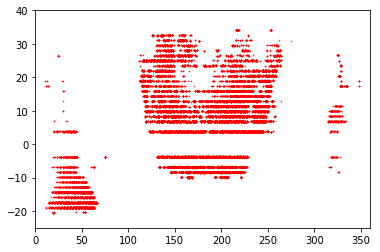

In [39]:
plt.plot(ra2[inside_only_2], dec2[inside_only_2], 'r.', markersize=1)
plt.axis([0, 360, -25, 40])
plt.show()

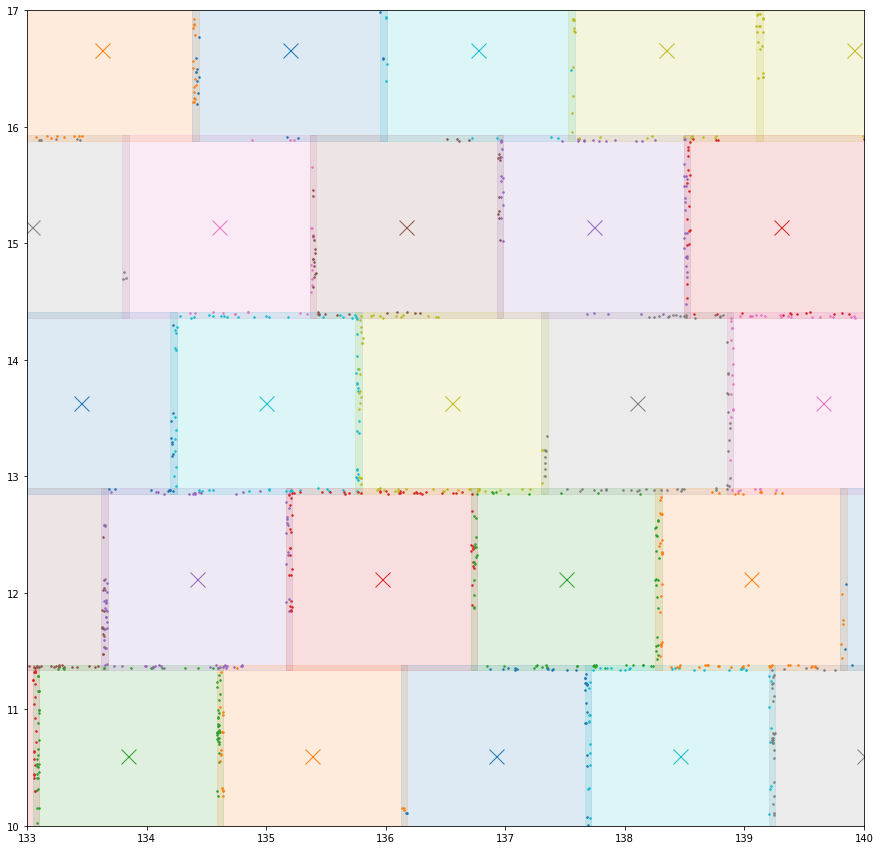

In [109]:
mask = mask_overlap

color_index = 0
fig, ax = plt.subplots(figsize=(15, 15))
for index in range(len(coadd)):
    if (130<ra1[index]<143) and (7<dec1[index]<21):
        ht = 1.5644
        wd = 1.5644/np.cos(dec1[index]/180*np.pi)
        ax.add_patch(
            patches.Rectangle(
                (ra1[index]-wd/2, dec1[index]-ht/2),  # (x,y)
                wd,  # width
                ht,  # height
                alpha=0.15,
                color='C{}'.format(color_index%10)
            )
        )
        plt.plot(ra1[index], dec1[index], 'C{}x'.format(color_index%10), markersize=15)
        mask1 = mask & (cat_coadd_id==index)
        plt.plot(ra2[mask1], dec2[mask1], 'C{}.'.format(color_index%10), markersize=3)
        color_index += 1

plt.axis([133, 140, 10, 17])
plt.show()

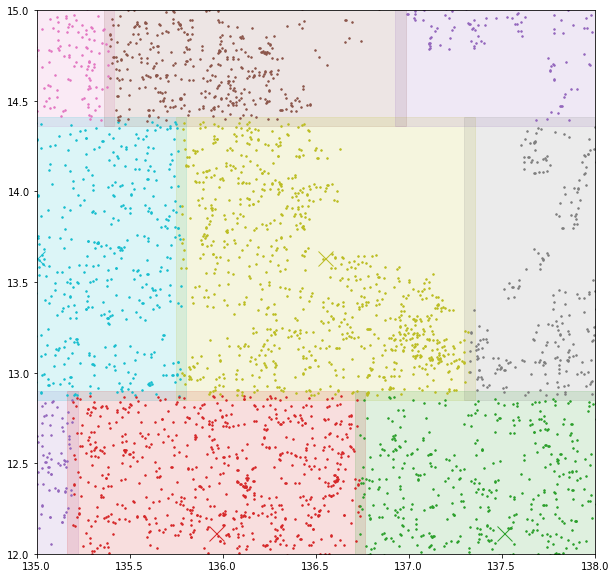

In [107]:
counter = 0
fig, ax = plt.subplots(figsize=(10, 10))
for index in range(len(coadd)):
    if (130<ra1[index]<143) and (7<dec1[index]<21):
        ht = 1.5644
        wd = 1.5644/np.cos(dec1[index]/180*np.pi)
        ax.add_patch(
            patches.Rectangle(
                (ra1[index]-wd/2, dec1[index]-ht/2),  # (x,y)
                wd,  # width
                ht,  # height
                alpha=0.15,
                color='C{}'.format(counter%10)
            )
        )
        plt.plot(ra1[index], dec1[index], 'C{}x'.format(counter%10), markersize=15)
        mask1 = (cat_coadd_id==index)
        plt.plot(ra2[mask1], dec2[mask1], 'C{}.'.format(counter%10), markersize=3)
        counter += 1

plt.axis([135, 138, 12, 15])
plt.show()

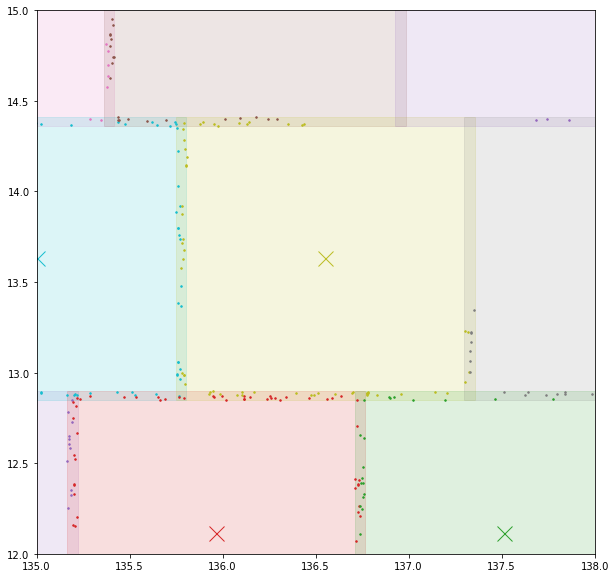

In [108]:
counter = 0
fig, ax = plt.subplots(figsize=(10, 10))
for index in range(len(coadd)):
    if (130<ra1[index]<143) and (7<dec1[index]<21):
        ht = 1.5644
        wd = 1.5644/np.cos(dec1[index]/180*np.pi)
        ax.add_patch(
            patches.Rectangle(
                (ra1[index]-wd/2, dec1[index]-ht/2),  # (x,y)
                wd,  # width
                ht,  # height
                alpha=0.15,
                color='C{}'.format(counter%10)
            )
        )
        plt.plot(ra1[index], dec1[index], 'C{}x'.format(counter%10), markersize=15)
        mask1 = mask_overlap & (cat_coadd_id==index)
        plt.plot(ra2[mask1], dec2[mask1], 'C{}.'.format(counter%10), markersize=3)
        counter += 1

plt.axis([135, 138, 12, 15])
plt.show()